# use case

## modified from:
## https://github.com/PlanQK/Routing/blob/master/Routing%20in%20directed%20graph.ipynb

# Routing in a directed graph
Consider a directed graph with edges $i=0, ..., N$ and edge costs $C_i$. We want to find a path from a start vertex to a target vertex. Let $X_i\in\{0,1\}$ be binary variables indicating if edge $i$ is chosen along the path.

The cost function is based on the following requirements:
- The start vertex has exactly one outgoing edge.
- The start vertex has no incoming edge.
- The target vertex has exactly one incoming edge.
- The target vertex has no outgoing edge.
- Every other vertex has
    - either one or zero incoming edges.
    - either one or zero outgoing edges.
    - an equal number of incoming and outgoing edges.


## Problem definition

In [12]:
## Cost function specification in sympy

import sympy as sym

# number of edges (Qubits)
N = sym.symbols('N')

# possible edges X_0, ..., X_{N-1} with values in {0,1}
X = sym.IndexedBase('X')

# costs for edges
C = sym.IndexedBase('C')

# penalty
P = sym.symbols('P')

# indices
i, j, k, v = sym.symbols('i j k v')

# start vertex: incoming and outgoing edges
VsI = sym.IndexedBase('VsI')    # incoming edges
LenVsI = sym.symbols('LenVsI')  # number of incoming edges
VsO = sym.IndexedBase('VsO')    # outgoing edges
LenVsO = sym.symbols('LenVsO')  # number of incoming edges

# target vertex: incoming and outgoing edges
VtI = sym.IndexedBase('VtI')    # incoming edges
LenVtI = sym.symbols('LenVtI')  # number of incoming edges
VtO = sym.IndexedBase('Vt O')   # outgoing edges
LenVtO = sym.symbols('LenVtO')  # number of incoming edges

# middle vertices: incoming and outgoing edges
# two indices: VI_(i,k) is the kth incoming edge at vertex i
# Similarly, LenVI_i is the number of incoming edges at vertex i
# the number of lists in LenVI and LenVO is the number of central vertices and must equal
LenV = sym.IndexedBase('LenV')   # number central vertices

VI = sym.IndexedBase('VI')        # incoming edges
LenVI = sym.IndexedBase('LenVI')  # number of incoming edges
VO = sym.IndexedBase('VO')        # outgoing edges
LenVO = sym.IndexedBase('LenVO')  # number of outgoing edges

transfer = sym.IndexedBase('transfer')

cost_function = (sym.Sum( C[i] * X[i] , (i,0,N-1) ) +                    # costs for edge i
    P * (sym.Sum( X[VsO[i]], (i, 0, LenVsO-1) ) - 1 )**2 +  # exactly one outgoing edge at start vertex
    P * sym.Sum( X[VsI[i]], (i, 0, LenVsI-1) ) +            # no incoming edge at start vertex
    P * (sym.Sum( X[VtI[i]], (i, 0, LenVtI-1) ) - 1 )**2 +  # exactly one incoming edge at target vertex
    P * sym.Sum( X[VtO[i]], (i, 0, LenVtO-1) ) +            # no outgoing edge at target vertex
    P * sym.Sum(                                            # one or zero incoming edges at each central point
        sym.Sum(  X[VI[v,i]] , (i, 0, LenVI[v]-1) ) *
        (sym.Sum(  X[VI[v,i]] , (i, 0, LenVI[v]-1) ) -1) ,
        (v, 0, LenV-1) ) +
    P * sym.Sum(                                            # one or zero outgoing edges at each central point
        sym.Sum(  X[VO[v,i]] , (i, 0, LenVO[v]-1) ) *
        (sym.Sum(  X[VO[v,i]] , (i, 0, LenVO[v]-1) ) -1) ,
        (v, 0, LenV-1) )  +
    P * sym.Sum(                                            # equal number of incoming and outgoing edges at each central point
        (sym.Sum(  X[VI[v,i]] , (i, 0, LenVI[v]-1) ) -
        sym.Sum(  X[VO[v,i]] , (i, 0, LenVO[v]-1) ))**2 ,
        (v, 0, LenV-1) ) +
    P * sym.Sum(                                            # one or zero outgoing edges at each central point
        sym.Sum(  X[VO[v,i]] , (i, 0, LenVO[v]-1) ) *
        (sym.Sum(  X[VO[v,i]] , (i, 0, LenVO[v]-1) ) -1) ,
        (v, 0, LenV-1) )+
        
        0.5 * sym.Sum( 2 *                                  # follow-up flight leaves a large enough transfer window
        sym.Sum(  sym.Sum( X[VI[v,i]] * X[VO[v,j]] *  transfer[ VI[v,i], VO[v,j] ] , (j, 0, LenVO[v]-1) ) , (i, 0, LenVI[v]-1) )
         , (v, 0, LenV-1) )
        
        )
cost_function

P*(Sum(X[VsO[i]], (i, 0, LenVsO - 1)) - 1)**2 + P*(Sum(X[VtI[i]], (i, 0, LenVtI - 1)) - 1)**2 + P*Sum((Sum(X[VI[v, i]], (i, 0, LenVI[v] - 1)) - 1)*Sum(X[VI[v, i]], (i, 0, LenVI[v] - 1)), (v, 0, LenV - 1)) + 2*P*Sum((Sum(X[VO[v, i]], (i, 0, LenVO[v] - 1)) - 1)*Sum(X[VO[v, i]], (i, 0, LenVO[v] - 1)), (v, 0, LenV - 1)) + P*Sum((Sum(X[VI[v, i]], (i, 0, LenVI[v] - 1)) - Sum(X[VO[v, i]], (i, 0, LenVO[v] - 1)))**2, (v, 0, LenV - 1)) + P*Sum(X[VsI[i]], (i, 0, LenVsI - 1)) + P*Sum(X[Vt O[i]], (i, 0, LenVtO - 1)) + Sum(C[i]*X[i], (i, 0, N - 1)) + 0.5*Sum(2*Sum(X[VI[v, i]]*X[VO[v, j]]*transfer[VI[v, i], VO[v, j]], (j, 0, LenVO[v] - 1), (i, 0, LenVI[v] - 1)), (v, 0, LenV - 1))

In [13]:
def transfer_check(edge_1, edge_2):
    """
    For two given flights, checks if the time inbetween is 
    smaller than the minimum transfer time. If yes, returns 
    the specified penalty value. If no, returns 0.
    """

    landing_time = TestC[edge_1][2]
    start_time = TestC[edge_2][1]

    if start_time - landing_time < Test_min_transfer_in_min:
        return TestP
    else:
        return 0

## Data input

In [3]:
TestN = 5               # number of edges
TestVsI = []            # indices of incoming edges at start vertex
TestVsO = [0,1]         # indices of outgoing edges at start vertex
TestVtI = [3,4]         # indices of incoming edges at target vertex
TestVtO = []            # indices of outgoing edges at target vertex
TestVI = [[0],[1,2]]    # indices of incoming edges at central vertices
TestVO = [[2,3],[4]]    # indices of outgoing edges at central vertices

#TestC = [2,4,1,7,3]

TestC = [[2, 3, 14], [4, 5, 9], [1, 81, 90], [7, 79, 86], [3, 100, 103]] # first component: generic cost. second: start time. third: landing time

TestP = 50
Test_min_transfer_in_min = 60

## Data processing

In [4]:
## translation of graph structure into dictionaries for sympy

single_valued_dict = {
    N: TestN,
    P: TestP,
    LenVsI: len(TestVsI),
    LenVsO: len(TestVsO),
    LenVtI: len(TestVtI),
    LenVtO: len(TestVtO),
    LenV:  len(TestVI)
}

# multi-valued dictionaries
dict_VsI = { VsI[k]: TestVsI[k] for k in range(len(TestVsI)) }

dict_VsO = { VsO[k]: TestVsO[k] for k in range(len(TestVsO)) }

dict_VtI = { VtI[k]: TestVtI[k] for k in range(len(TestVtI)) }

dict_VtO = { VtO[k]: TestVtO[k] for k in range(len(TestVtO)) }

dict_LenVI = { LenVI[k]: len(TestVI[k]) for k in range(len(TestVI)) }

dict_LenVO = { LenVO[k]: len(TestVO[k]) for k in range(len(TestVO)) }

dict_VI = { VI[k, i]: TestVI[k][i] for k in range(len(TestVI)) for i in range(len(TestVI[k])) }

dict_VO = { VO[k, i]: TestVO[k][i] for k in range(len(TestVO)) for i in range(len(TestVO[k])) }

transfer_dict = {transfer[edge_1, edge_2]: transfer_check(edge_1, edge_2) for v in range(len(TestVI)) for edge_1 in TestVI[v] for edge_2 in TestVO[v]}


num_qubits = TestN

dict_costs = { C[k]: TestC[k][0] for k in range(len(TestC)) } ##

# definition of cost polynomial
cost_poly = sym.Poly(cost_function
                     .subs(single_valued_dict)
                     .doit()
                     .subs(dict_VsI)
                     .subs(dict_VsO)
                     .subs(dict_VtI)
                     .subs(dict_VtO)
                     .doit()
                     .subs(dict_LenVI)
                     .doit()
                     .subs(dict_LenVO)
                     .doit()
                     .subs(dict_VI)
                     .subs(dict_VO)
                     .subs(transfer_dict)
                     .doit()
                     .doit()
                     .subs(dict_costs)
                     ,
                     [X[i] for i in range(num_qubits)])
# in order to visualize the QUBO-matrix
# do not set P in single_valued_dict
# and do not substitute the cost in cost_poly
# then proceed as in the minimal optimization example

cost_poly

Poly(150.0*X[0]**2 + 100.0*X[0]*X[1] - 100.0*X[0]*X[2] - 100.0*X[0]*X[3] - 148.0*X[0] + 150.0*X[1]**2 + 200.0*X[1]*X[2] - 100.0*X[1]*X[4] - 146.0*X[1] + 250.0*X[2]**2 + 300.0*X[2]*X[3] - 50.0*X[2]*X[4] - 149.0*X[2] + 200.0*X[3]**2 + 100.0*X[3]*X[4] - 193.0*X[3] + 200.0*X[4]**2 - 197.0*X[4] + 100.0, X[0], X[1], X[2], X[3], X[4], domain='RR')

## QAOA

In [5]:
import qiskit
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.test.mock import *

# generate qiskit's cost function
qiskit_cost_function = QuadraticProgram()

# define qiskit variables
for i in range(num_qubits):
    qiskit_cost_function.binary_var('X_' + str(i))

# specify qiskit cost function
qiskit_cost_function.minimize(
    linear = [int(cost_poly.coeff_monomial(X[i]**1)) for i in range(num_qubits)],
    quadratic = {
        ('X_'+str(i), 'X_'+str(j)): cost_poly.coeff_monomial(X[i]**1 * X[j]**1)
        for i in range(num_qubits)
        for j in range(i,num_qubits)
    })

In [8]:
qaoa = QAOA(reps=1,quantum_instance =
             QuantumInstance(backend=qiskit.Aer.get_backend('qasm_simulator'), skip_qobj_validation=False))
optimizer_qaoa = MinimumEigenOptimizer(qaoa)

results = []

for i in range(10):
    result_qaoa = optimizer_qaoa.solve(qiskit_cost_function)
    results.append(result_qaoa)

## Results

In [9]:
qubit_results = []
for result in results:
    qubit_string = str(result.x).replace(' ', '').replace('.', '')[1:-1]
    qubit_results.append(qubit_string)
qubit_results

['01001',
 '01001',
 '01001',
 '01001',
 '01001',
 '01001',
 '01001',
 '10010',
 '01001',
 '01001']

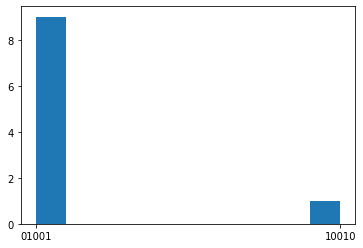

In [11]:
import matplotlib.pyplot as plt

plt.hist(qubit_results, bins = len(qubit_results))
plt.show()